<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Найдем-гиперпараметры" data-toc-modified-id="Найдем-гиперпараметры-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Найдем гиперпараметры</a></span></li><li><span><a href="#обучим-модели" data-toc-modified-id="обучим-модели-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>обучим модели</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [94]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import PowerTransformer
from itertools import product

<b>Откроем файл и изучим его<b/>

In [95]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [96]:
display(df.info())
display(df.head(5))
display('Количество явных дубликтов:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


'Количество явных дубликтов:'

26415

In [97]:
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

<b>Проверим данные на монотонность</b>

In [98]:
print(df.index.is_monotonic)

True


__Выполним ресемплирование по одному часу__

<AxesSubplot:xlabel='datetime'>

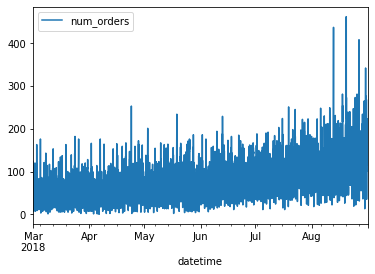

In [99]:
df = df.resample('1H').sum()
df.plot()

## Анализ

__Добавим столбец - 'rolling_mean' скользящее среднее с размером окна, равным 10__

<AxesSubplot:xlabel='datetime'>

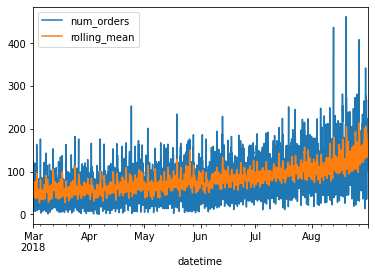

In [111]:
df1.plot()

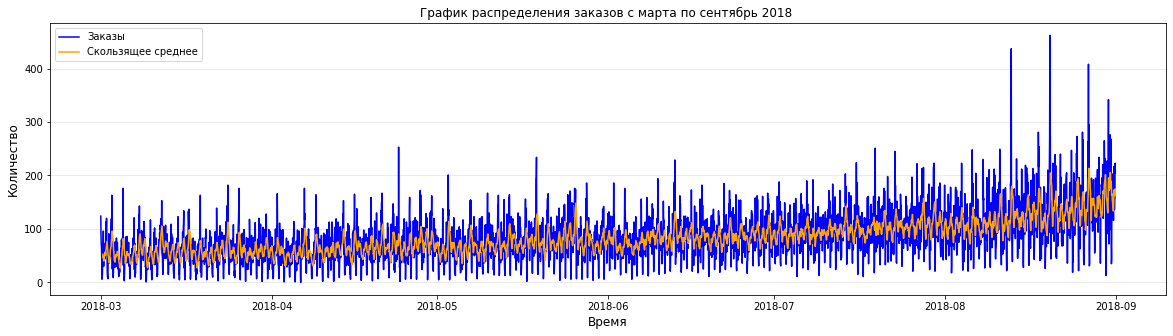

In [141]:
df1 = df.copy()
df1['rolling_mean'] = df.rolling(10).mean() 
plt.figure(figsize=(20, 5))
plt.plot(df1['num_orders'], "blue", label="Заказы")
plt.plot(df1['rolling_mean'], "orange", label="Скользящее среднее")
plt.title('График распределения заказов с марта по сентябрь 2018 ')
plt.xlabel('Время', fontsize=12, color='black')
plt.ylabel('Количество', fontsize=12, color='black')
plt.grid(axis='y', alpha=.3)
plt.legend()
plt.show()

__Разложим временной ряд на тренд и сезонную компоненту__

In [142]:
decomposed = seasonal_decompose(df)

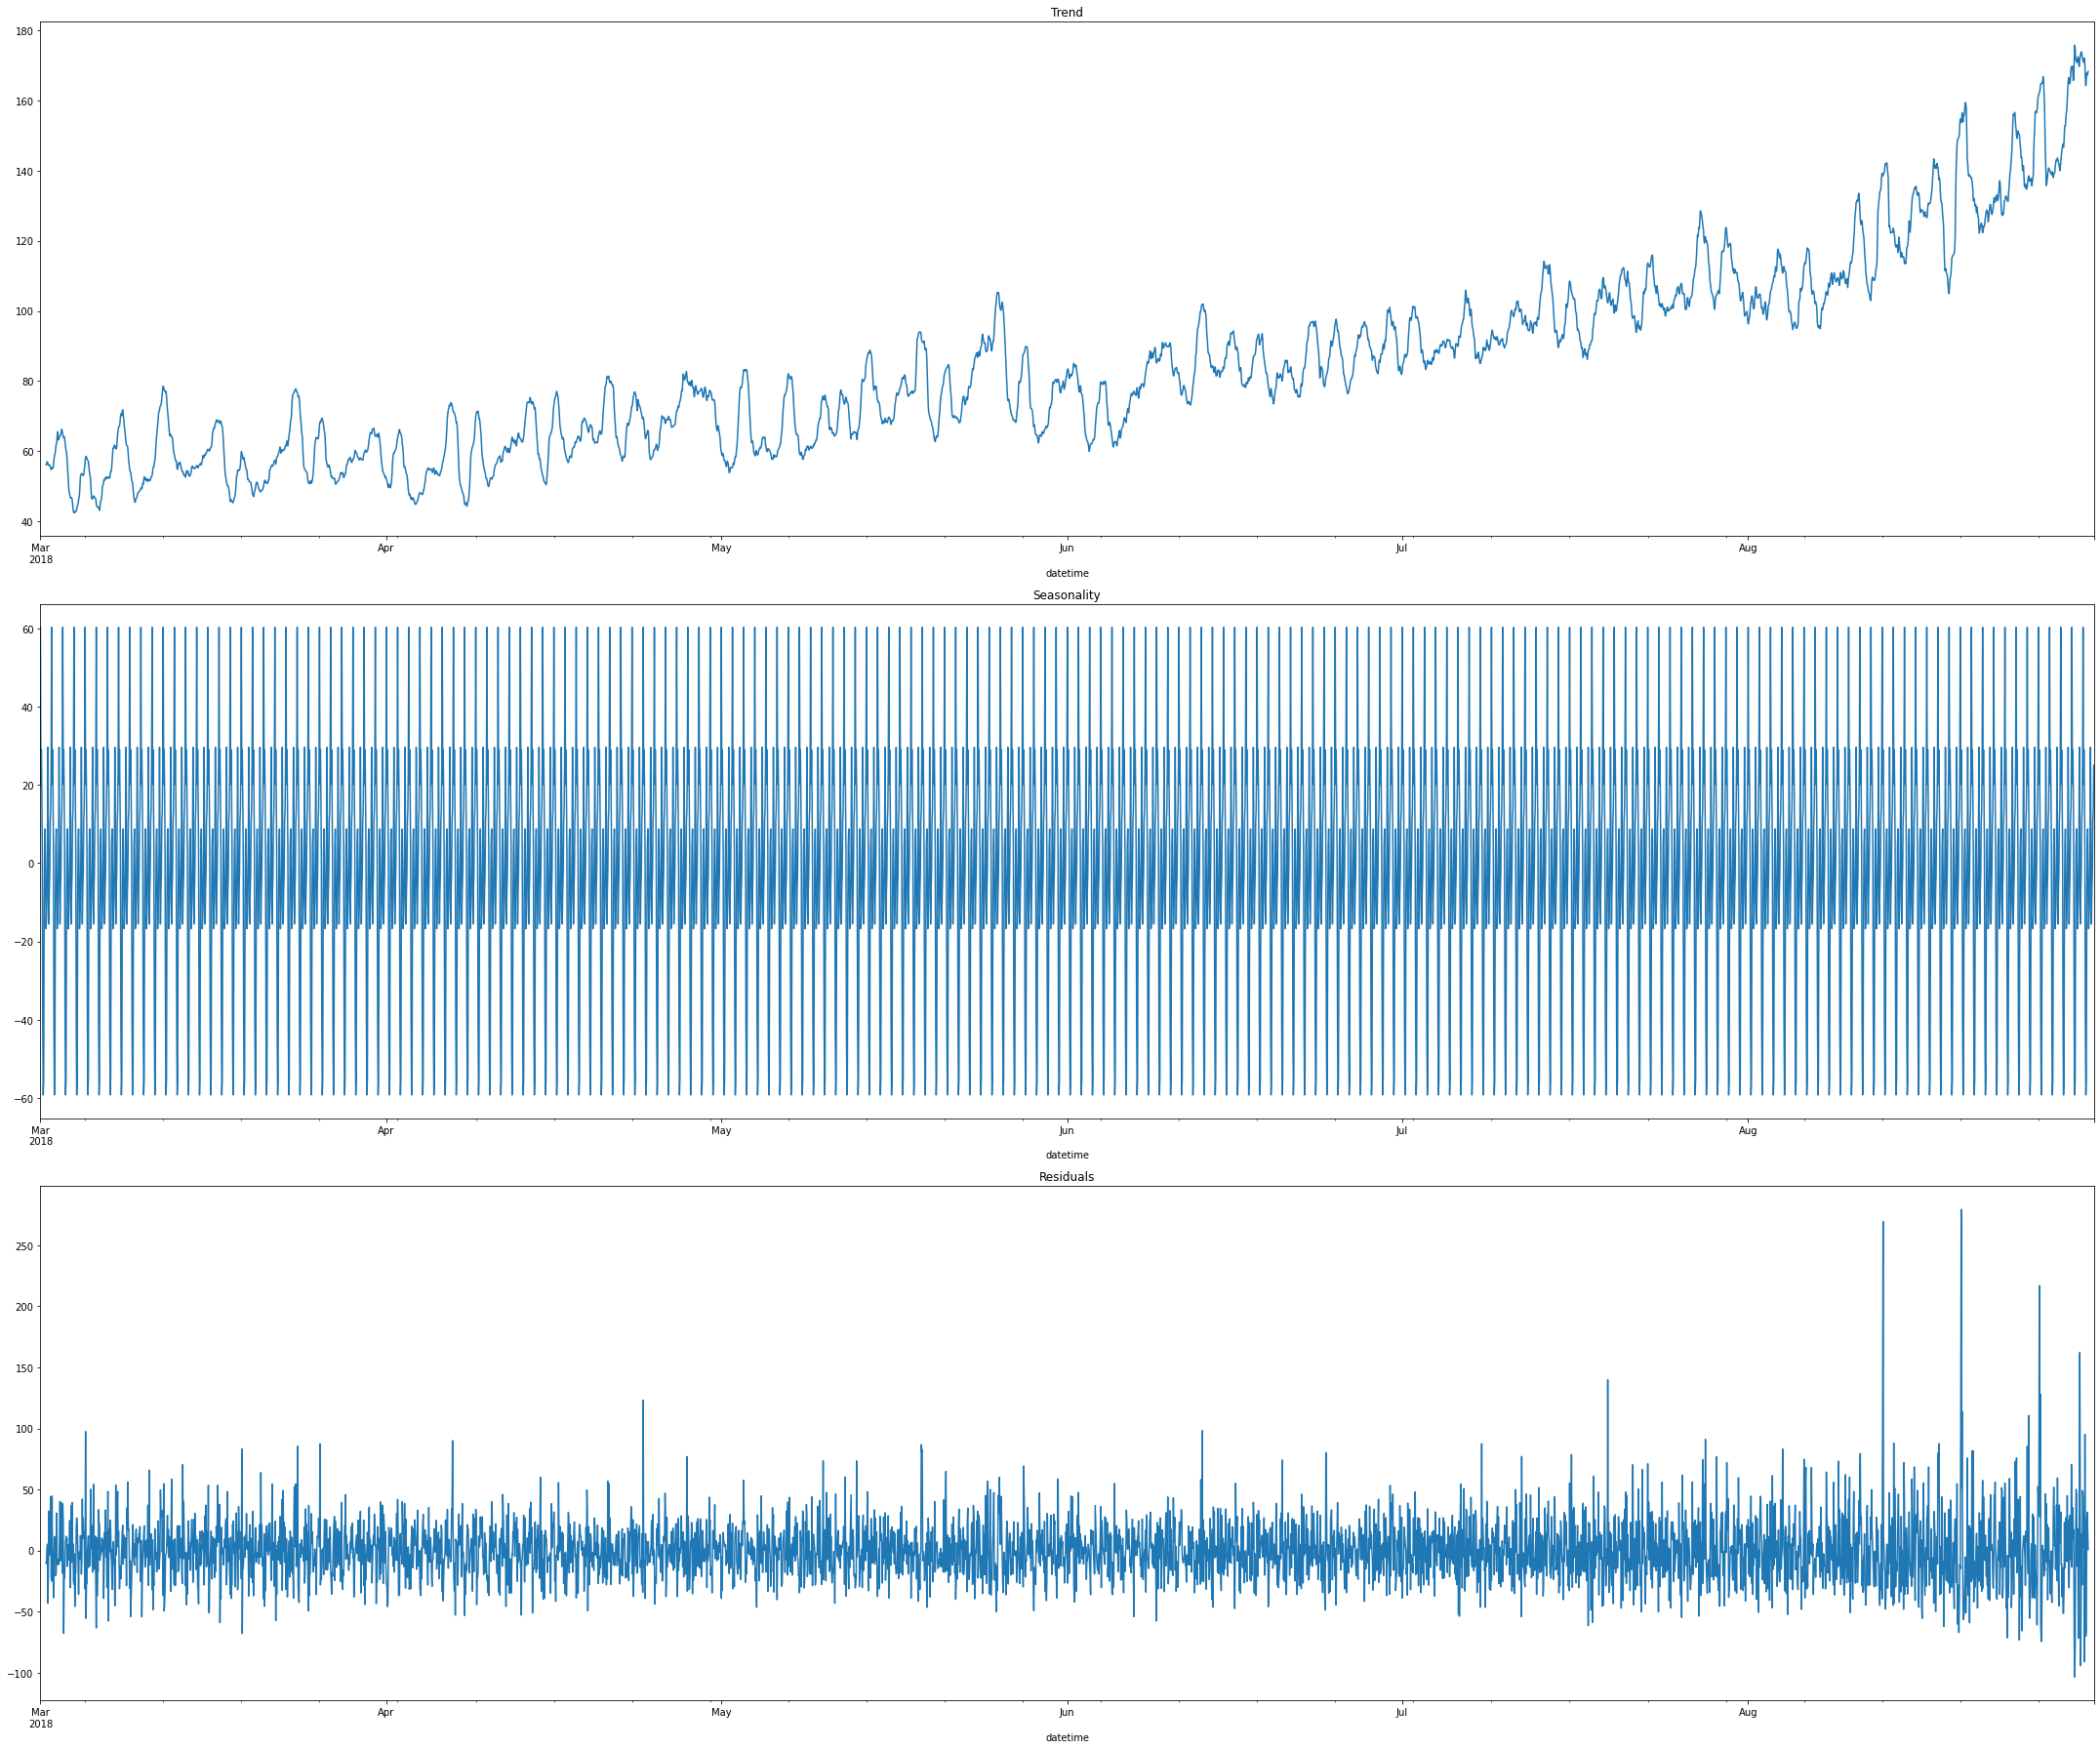

In [143]:
plt.figure(figsize=(30, 25))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд - восходящий, видимо поездки за исследуемый период только увеличивались. Временной ряд не стационарный - у него меняется среднее значение.

Сезонность пока не понять. Посмотрим более детально но в разрезе одной недели в начале и в конце анализируемого периода.


<b>

По графику тренда заметно, что к концу лета количество заказов в час увеличилось.
</b>

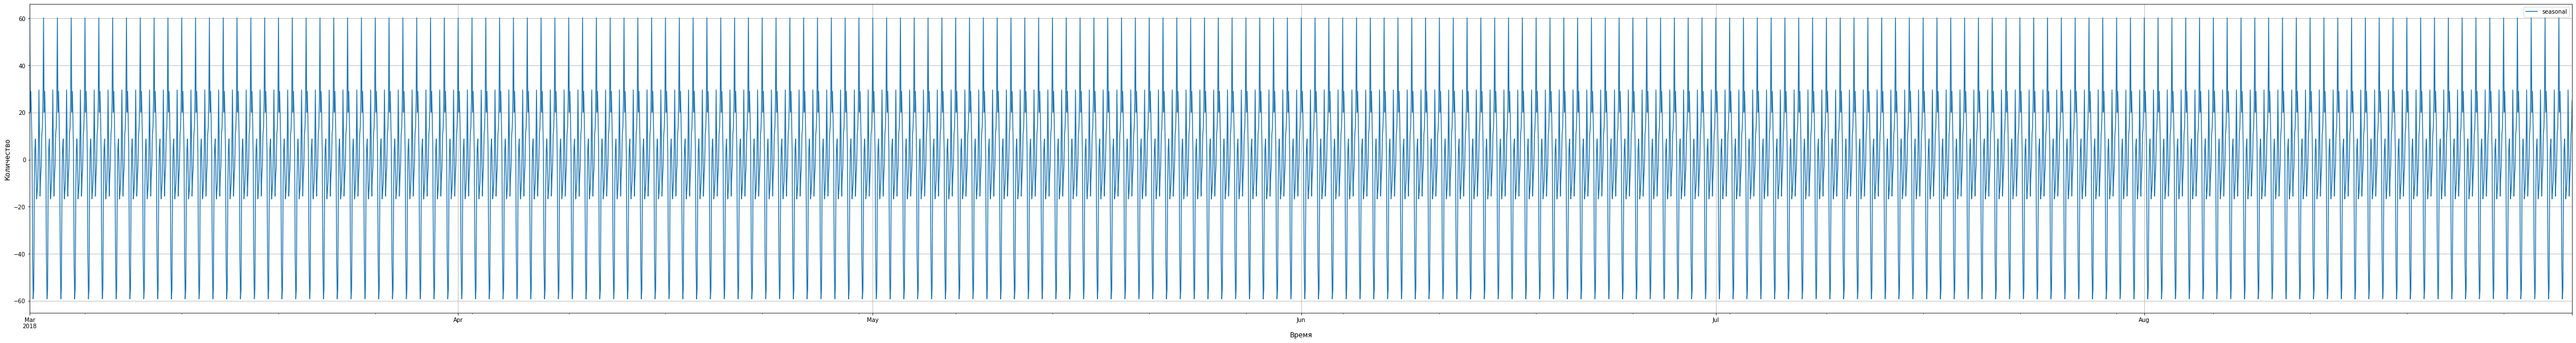

In [152]:
plt.figure(figsize=(80, 10))
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel('Время', fontsize=12, color='black')
plt.ylabel('Количество', fontsize=12, color='black')
plt.grid()
plt.legend()
plt.show()

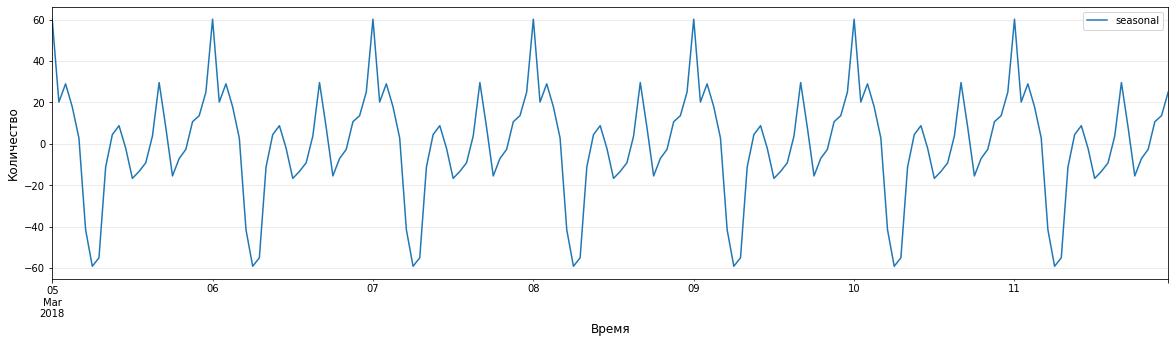

In [144]:
plt.figure(figsize=(20, 5))
decomposed.seasonal['2018-03-05':'2018-03-11'].plot(ax=plt.gca())
plt.xlabel('Время', fontsize=12, color='black')
plt.ylabel('Количество', fontsize=12, color='black')
plt.grid(axis='y', alpha=.3)
plt.legend()
plt.show()

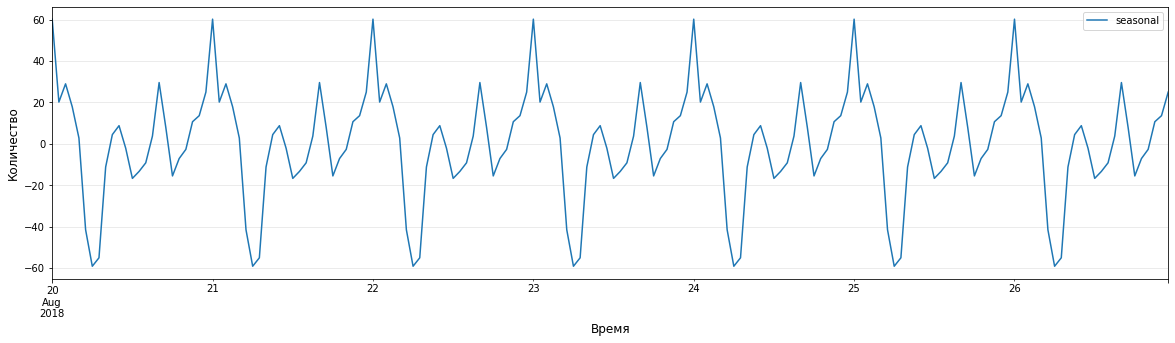

In [146]:
plt.figure(figsize=(20, 5))
decomposed.seasonal['2018-08-20':'2018-08-26'].plot(ax=plt.gca())
plt.xlabel('Время', fontsize=12, color='black')
plt.ylabel('Количество', fontsize=12, color='black')
plt.grid(axis='y', alpha=.3)
plt.legend()
plt.show()

Каких-то вспесков отдельно в будний или в выходной день не наблюдаю, следовательно нагрузка комлпексно растёт. Сердцебиение говорит о том, что в с утра поездок меньше всего а максимум вечером после окончания рабочего дня. Странно что в выходные эта сезонность сохраняется.

<b>

    
- Судя по тому, что я понял, в данном случае мы имеем дело с суточной сезонностью. Нет сезонности в зависимости от сезона(лето/осень/зима/весна) т.к. мы наблюдает стабильный рост заказаов с начала анализируемого периода;
- Ближе к вечеру поток поездок увеличивается, а рано утром он самый слабый;
- Судя, по всему большая часть полетов приходится на вечерное время, а не на утреннее т.к. после работы у людей меньше всего свободного времени которым они распологаеют до начала рейса. Если, условно, рейс утром, то люди берут отгул или у них уже начался отпуск и они имеют возможность заранее приехать  в аэропорт. 
    
    
</b>

__Создадим признаки для обучения модели.__

In [187]:
def make_features(df, column, max_lag, rolling_mean_size):
    df2 = df.copy()
    #df2['year'] = df2.index.year
    #df2['month'] = df2.index.month
    df2['dayofweek'] = df2.index.dayofweek
    df2['hour'] = df2.index.hour
    
    for lag in range(1, max_lag + 1):
        df2['lag_{}'.format(lag)] = df2[column].shift(lag)

    df2['rolling_mean'] = df2[column].shift().rolling(4).mean()
    return df2

__Разбейте датасет на обучающую и тестовую выборки__

In [189]:
df2 = make_features(df,'num_orders', 2, 10)

In [191]:
train, test = train_test_split(df2.copy(), shuffle=False, test_size=0.1)
train = train.dropna()

In [192]:
features_train  = train.drop('num_orders', axis=1)
target_train = train[['num_orders']]
features_test = test.drop('num_orders', axis=1)
target_test = test[['num_orders']]

## Обучение

Мы будем использовать 4 модели:
- LinearRegression;
- DecisionTreeRegressor;
- CatBoostRegressor;
- LGBMRegressor.

Из них выберем лучшую по критерию лучшего показателя и времени обучения.

Напишем функцию rmse

In [193]:
def rmse(y, predictions):
    return mse(y, predictions) ** .5

rmse_score = make_scorer(rmse, greater_is_better=False)

Стандартизируем численные признаки при помощи StandardScaler

In [197]:
scaler = StandardScaler()

X_train = scaler.fit_transform(features_train)
X_test = scaler.transform(features_test)
X_train_norm = features_train
X_test_norm = features_test
y_train = target_train
y_test = target_test

Размерности наших выборок вот такие:

In [198]:
X_train.shape

(3970, 5)

In [199]:
X_test.shape

(442, 5)

### Найдем гиперпараметры

<b>
Попробуем использовать GreedSeacrhCV 
</b> 

In [210]:
%%time
state = 42
tscv = TimeSeriesSplit(n_splits=8)
model = DecisionTreeRegressor(random_state=state)
    

param_dict = {'max_depth': range(1, 8),
              'min_samples_leaf' : range (1,6),
              'max_features' : range(1,7)}

griddtr = GridSearchCV(model, param_dict, cv=tscv, scoring='neg_mean_squared_error', n_jobs = -1)

griddtr.fit(features_train, target_train)
griddtr.best_score_

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 288, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_features]

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to na

CPU times: user 11.7 s, sys: 71.5 ms, total: 11.8 s
Wall time: 11.8 s


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 288, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_features]

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to na

-841.0841229021659

In [211]:
print(griddtr.best_estimator_)
print()
print(griddtr.best_params_)
print()
print(griddtr.best_score_)

DecisionTreeRegressor(max_depth=7, max_features=4, min_samples_leaf=3,
                      random_state=42)

{'max_depth': 7, 'max_features': 4, 'min_samples_leaf': 3}

-841.0841229021659


In [212]:
%%time
state = 42
tscv = TimeSeriesSplit(n_splits=8)
model = LinearRegression()
    

param_dict = {'fit_intercept':[True, False],
                    'copy_X':[True, False]}

griddlr = GridSearchCV(model, param_dict, cv = tscv, scoring='neg_mean_squared_error', n_jobs = -1)
griddlr.fit(X_train, y_train)
griddlr.best_score_

CPU times: user 155 ms, sys: 110 µs, total: 155 ms
Wall time: 155 ms


-1070.9088311964792

In [213]:
print(griddlr.best_estimator_)
print()
print(griddlr.best_params_)
print()
print(griddlr.best_score_)

LinearRegression()

{'copy_X': True, 'fit_intercept': True}

-1070.9088311964792


In [224]:
model = CatBoostRegressor() 
tscv = TimeSeriesSplit(n_splits=8)
param_dict = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[42],
                'verbose':[False]}]

print()
gridcb = GridSearchCV(model, param_dict, cv = tscv,scoring='neg_mean_squared_error')
gridcb.fit(features_train, target_train)
gridcb.best_score_

-711.2155461621752

In [225]:
%%time
print(gridcb.best_estimator_)
print()
print(gridcb.best_params_)
print()
print(gridcb.best_score_)


{'learning_rate': 0.1, 'random_state': 42, 'verbose': False}

-711.2155461621752
CPU times: user 895 µs, sys: 10 µs, total: 905 µs
Wall time: 592 µs


In [231]:
model = LGBMRegressor() 
tscv = TimeSeriesSplit(n_splits=8)
param_dict = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[42]
             }]
print()
gridlgmr = GridSearchCV(model, param_dict, cv = tscv,scoring='neg_mean_squared_error',n_jobs = -1)
gridlgmr.fit(features_train, target_train)
gridlgmr.best_score_

-698.5288591029301

In [232]:
%%time
print(gridlgmr.best_estimator_)
print()
print(gridlgmr.best_params_)
print()
print(gridlgmr.best_score_)

LGBMRegressor(random_state=42)

{'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 42}

-698.5288591029301
CPU times: user 926 µs, sys: 10 µs, total: 936 µs
Wall time: 768 µs


### Oбучим модели

In [218]:
model1 = DecisionTreeRegressor(random_state=42,
                               max_depth =7, 
                               max_features=4,
                               min_samples_leaf=3) 
start = time.time()
model1.fit(features_train, target_train) 
fit_time = time.time() - start
predictions_1 = model1.predict(features_test) # получим предсказания модели
pred_time = time.time() - start
result1 = rmse(target_test,predictions_1)


print('DecisionTreeRegressor: ', result1)
print("Время обучения: ", fit_time)
print("Время предсказания: ", pred_time)

DecisionTreeRegressor:  55.31398826473888
Время обучения:  0.008613348007202148
Время предсказания:  0.010343790054321289


На стандартизированной выборке

In [223]:
model2 = LinearRegression(copy_X = True,
                          fit_intercept = True) 
start = time.time()
model2.fit(X_train, y_train) 
fit_time = time.time() - start
predictions_2 = model2.predict(X_test) # получим предсказания модели
pred_time = time.time() - start
result2 = rmse(y_test,predictions_2)


print('LinearRegression: ', result2)
print("Время обучения: ", fit_time)
print("Время предсказания: ", pred_time)

LinearRegression:  56.55468336148972
Время обучения:  0.0035123825073242188
Время предсказания:  0.003752470016479492


На не стандартизированной выборке

In [226]:
model2 = LinearRegression(copy_X = True,
                          fit_intercept = True) 
start = time.time()
model2.fit(features_train, target_train) 
fit_time = time.time() - start
predictions_2 = model2.predict(X_test) # получим предсказания модели
pred_time = time.time() - start
result2 = rmse(y_test,predictions_2)


print('LinearRegression: ', result2)
print("Время обучения: ", fit_time)
print("Время предсказания: ", pred_time)

LinearRegression:  127.1236133057961
Время обучения:  0.005657672882080078
Время предсказания:  0.005895376205444336


In [220]:
model3 = CatBoostRegressor(learning_rate = 0.1,
                           random_state = 42,
                           verbose = False) 
start = time.time()
model3.fit(features_train, target_train) 
fit_time = time.time() - start
predictions_3 = model3.predict(features_test) # получим предсказания модели
pred_time = time.time() - start
result3 = rmse(target_test,predictions_3)


print("CatBoostRegressor", result3)
print("Время обучения: ", fit_time)
print("Время предсказания: ", pred_time)

CatBoostRegressor 50.50799473447867
Время обучения:  2.1492955684661865
Время предсказания:  2.1510446071624756


In [239]:
model4 = LGBMRegressor(learning_rate= 0.1,
                       num_leaves=31,
                       random_state= 42,
                      boosting_type='gbdt') 
start = time.time()
model4.fit(features_train, target_train) 
fit_time = time.time() - start
predictions_4 = model4.predict(features_test) # получим предсказания модели
pred_time = time.time() - start
result4 = rmse(target_test,predictions_4)


print('LGBMRegressor: ', result4)
print("Время обучения: ", fit_time)
print("Время предсказания: ", pred_time)

LGBMRegressor:  49.72141718548664
Время обучения:  275.8616180419922
Время предсказания:  275.87224411964417



    
    
Результаты такие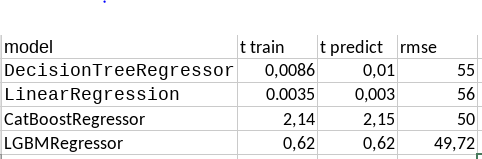
    


### Итоговый вывод

Быстрее всего и обучается и предсказывает Линейная регрессия, показатель rmse  у нее также самый высокий.

- На первом этапе был проведен первичный корректности данных. Данные были проверены на наличие явных дубликатов, монотонность, а также были выведены максимумы и минимумы по индексу. 
- Далее было проведено ресемплирование по одному часу.
- На следующем этапе был проведен анализ самих данных. Были пострены графики по количеству заказов за весь период, со скользящим средним.
- Также были построены графики сезонности и остатков. На основании данных по сезонности было заключено, что это сезонность дневная. Ближе к вечеру наблюдается пик, с утра показатели количества - самые низкие.
- На следующем этапе выборка была разделена на  обучающую и тестовую. Специально для Линейной регрессии данные были стандартизированы.
- Анализировались 4 модели (DecisionTreeRegressor,LinearRegression,CatBoostRegressor,LGBMRegressor). Для каждой были подобраны гиперпараметры, при помощи GridSearchCV, а также кросс-валидатора временных рядом TimeSeriesSplit.
- После модели были обучены и предсказали значения из тестовой выборки. Лучшие значения показала модель LGBMRegressor с показателем 49,72.  